In [11]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [12]:
import pandas as pd
import numpy as np
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

import gc
import pickle as pickle

from sklearn.model_selection import KFold
from itertools import product
import tensorflow as tf
from sklearn.preprocessing import StandardScaler,MinMaxScaler 
import multiprocessing as mp
import importlib
from sklearn.model_selection import train_test_split

In [13]:
#tail -n +2 train.csv | split -l 150000


In [14]:
from os import listdir
from os.path import isfile, join

TRAIN_SPLITS='train'
splits = [f for f in listdir(TRAIN_SPLITS) if isfile(join(TRAIN_SPLITS, f))]

In [109]:
path = 'train/%s' % (np.random.choice(splits))
#
columns = ['acoustic_data','time_to_failure']
df = pd.read_csv(path, float_precision='round_trip', header=None)
df.columns = columns

df.describe()

,acoustic_data,time_to_failure
count,150000.000000,150000.000000
mean,4.446447,8.347519
std,4.526525,0.011252
min,-60.000000,8.327998
25%,2.000000,8.337599
50%,4.000000,8.347099
75%,7.000000,8.357796
max,72.000000,8.367396


In [65]:
path1 = 'train/%s' % (np.random.choice(splits))
#
columns = ['acoustic_data','time_to_failure']
df1 = pd.read_csv(path1, float_precision='round_trip', header=None)
df1.columns = columns

path2 = 'train/%s' % (np.random.choice(splits))
#
columns = ['acoustic_data','time_to_failure']
df2 = pd.read_csv(path2, float_precision='round_trip', header=None)
df2.columns = columns

In [ ]:
np.random.choice(np.array([1,2,3,4]))
for i in range(0,20):
    print(i)

In [ ]:
acoustic_data = np.array_split(df['acoustic_data'].values, 300)

np.random.choice(acoustic_data[0])

In [ ]:

#last_n=int(SEGMENT_LENGTH/timesteps/4)
acoustic_data = np.array_split(df['acoustic_data'].values, 500)
#means = np.array([np.mean(sub[-last_n:], dtype=np.float64) for sub in acoustic_data])
data = np.array([(np.mean(sub),np.max(sub),np.min(sub)) for sub in acoustic_data])
target = df['time_to_failure'].values[-1]
#
df2 = pd.DataFrame(data)
df2.columns = ["mean", "max", "min"]

In [ ]:
df2

In [6]:
a = np.array([1,2,-3,4,50,-1,2,3])
a[a > 3]

array([ 4, 50])

In [101]:
TIMESTEPS=200

import build_segment
importlib.reload(build_segment)

from build_segment import build_segment_f

split_chunks = np.array_split(splits,mp.cpu_count())

if __name__ ==  '__main__':
    pool = mp.Pool(mp.cpu_count())
    res = [pool.apply_async(build_segment_f,args=[chunk,TIMESTEPS]) for chunk in split_chunks]
    pool.close()
    pool.join()

0
0
0
0
0
0
0
0
100
100
100
100
100
100
100
100
200
200
200
200
200
200
200
200
300
300
300
300
300
300
300
300
400
400
400
400
400
400
400
400
500
500
500
500
500
500
500
500


In [60]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

res[0].get()[100]['mean'].shift(10)

TypeError: 'NoneType' object does not support item assignment

In [102]:
NUMBER_OF_FEATURES=len(res[0].get()[0].drop('time_to_failure', axis=1).columns)

training = np.empty((len(splits),TIMESTEPS,NUMBER_OF_FEATURES),dtype=float)
targets = np.empty((len(splits),1),dtype=float)
i=0
for r in res:
    for df in r.get():
        training[i] = df.drop('time_to_failure', axis=1)
        targets[i] = np.array([df['time_to_failure'].unique()])
        i+=1

In [106]:
res[0].get()[0]

,mean,max,min,std,abs,q25,q50,q75,sum,uniq,pos,negs,ssum,imax,imin,abs_nrg,abs_sum_chg,autocorr_10,cid_ce,kurtosis,mean_chg,reocurring_pct,r_sigma,ratio_to_length,skewness,rolling_10,rolling_25,lag_10,lag_25,time_to_failure
0,1.463176,-0.486669,0.543129,-0.513734,-0.516637,0.805610,0.913812,0.027098,1.463176,-0.577075,1.053977,-0.890891,-0.300058,0.190477,0.426873,-0.314841,-0.530997,0.714911,0.967506,-0.456510,0.665644,0.194991,0.082402,-0.577075,0.576101,1.463176,1.463176,0.073178,0.282093,1.158496
1,0.226485,-0.390012,0.445881,-0.469267,-0.419342,0.805610,-0.101535,-0.958294,0.226485,-0.462878,0.752841,-0.743323,-0.416063,-0.817325,-0.568664,-0.333744,-0.341296,0.723861,0.824545,-0.460639,-0.621513,-0.277092,-1.160165,-0.462878,0.550578,0.844831,0.844831,0.073178,0.282093,1.158496
2,-0.280032,0.044946,0.105514,-0.124406,-0.030161,-0.077250,-1.116881,0.027098,-0.280032,0.070041,-0.202488,0.173709,-0.206799,-0.287234,-0.282307,-0.229991,-0.267324,-0.915024,-0.530870,0.437142,0.114005,-0.737071,0.605588,0.070041,0.912642,0.469877,0.469877,0.073178,0.282093,1.158496
3,1.426997,-0.341683,0.251386,-0.350470,-0.297723,0.805610,0.913812,0.027098,1.426997,-0.310616,0.597081,-0.564132,-0.209453,1.659226,1.722188,-0.268437,-0.368737,0.085453,0.258190,-0.170290,1.033403,0.041354,0.670986,-0.310616,-0.678955,0.709157,0.709157,0.073178,0.282093,1.158496
4,0.686955,3.379621,-3.395407,2.937287,3.399488,-0.077250,0.913812,0.273446,0.686955,3.229489,-0.597081,0.848307,2.313462,1.259039,1.263570,2.605711,2.174935,-2.250054,-2.274277,4.141594,2.504438,-2.416572,1.848155,3.229489,-2.940272,0.704716,0.704716,0.073178,0.282093,1.158496
5,-0.704322,1.398147,-1.790818,1.925065,1.599530,-1.842971,-1.116881,1.997882,-0.704322,2.049454,-2.549276,2.598045,1.930191,-1.207036,-1.371804,1.287853,2.040116,-2.097579,-2.024815,0.913416,-3.563584,-0.622076,1.978952,2.049454,-0.493427,0.469877,0.469877,0.073178,0.282093,1.158496
6,-0.997049,-0.390012,0.300009,-0.248294,-0.346370,-0.077250,-1.116881,0.027098,-0.997049,-0.348681,-0.503625,0.321277,-0.377395,1.336562,0.760209,-0.293075,-0.256586,-0.401121,-0.131623,-0.568861,0.665644,-0.028704,-0.440784,-0.348681,0.003671,0.260316,0.260316,0.073178,0.282093,1.158496
7,-0.885221,-0.486669,0.300009,-0.370959,-0.395018,-0.077250,-1.116881,-0.958294,-0.885221,-0.424813,0.192104,-0.174131,-0.457006,-1.123227,0.120382,-0.331196,-0.329365,0.293101,0.294854,-0.517366,-0.621513,-0.847066,-0.113793,-0.424813,-0.353589,0.117124,0.117124,0.073178,0.282093,1.158496
8,0.124524,-0.486669,0.591753,-0.496974,-0.540960,0.805610,-1.116881,-0.958294,0.124524,-0.615141,0.908601,-0.848728,-0.449803,-0.917895,-1.101108,-0.343766,-0.464184,0.829185,0.931024,-0.529375,-1.173151,1.792811,-1.552555,-0.615141,1.549470,0.117946,0.117946,0.073178,0.282093,1.158496
9,-0.332657,-0.534998,0.445881,-0.465152,-0.492313,0.805610,0.913812,-0.958294,-0.332657,-0.539009,0.482857,-0.479808,-0.434260,-1.225893,0.158413,-0.346023,-0.330558,0.471892,0.867642,-0.498892,1.033403,0.274882,-0.440784,-0.539009,-1.872663,0.072886,0.072886,0.073178,0.282093,1.158496


In [ ]:
res[0].get()[0][['acoustic_data', 'rolling_10', 'rolling_50', 'rolling_100', 'min_50',
       'max_50', 'std_50']].shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 24)                5184      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 25        
Total params: 5,209
Trainable params: 5,209
Non-trainable params: 0
_________________________________________________________________
Train on 3775 samples, validate on 420 samples
Epoch 1/100
3775/3775 [==============================] - 15s 4ms/step - loss: 3.4187 - mean_absolute_error: 3.4187 - val_loss: 3.0263 - val_mean_absolute_error: 3.0263
Epoch 2/100
3775/3775 [==============================] - 10s 3ms/step - loss: 2.9005 - mean_absolute_error: 2.9005 - val_loss: 2.8061 - val_mean_absolute_error: 2.8061
Epoch 3/100
3775/3775 [==============================] - 10s 3ms/step - loss: 2.4482 - mean_absolute_error: 2.4482 - val_loss: 2.4763 - val_mean_absolute

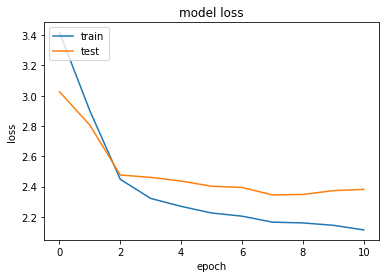

In [105]:
train_data, val_data, y_train, y_val = train_test_split(training, targets, test_size=0.1, random_state=42)

from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Flatten,GRU#,CuDNNGRU,CuDNNLSTM
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.layers import Bidirectional



dropout=0.2
BATCH_SIZE=16


my_model = Sequential()

my_model.add(LSTM(use_bias = True,unit_forget_bias=True,\
                  units = 24,\
                  #stateful=True,
                    #batch_input_shape=(BATCH_SIZE,TIMESTEPS,1),\
                  input_shape=(TIMESTEPS, NUMBER_OF_FEATURES),
                  #dropout=dropout,recurrent_dropout=dropout,
                  #return_sequences=True
                  ))


#my_model.add(BatchNormalization())


                 
                    
#my_model.add(Dense(8))
#my_model.add(BatchNormalization())
my_model.add(Dense(1))

my_model.compile(loss = 'mae',optimizer = 'adam', metrics = ['mean_absolute_error'])
my_model.summary()

from keras.callbacks import Callback

class Reseter(Callback):
    def on_epoch_end(self, epoch, logs=None):
        self.reset_states()


callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=0),
    #Reseter()
]

history = my_model.fit(train_data, y_train, batch_size=BATCH_SIZE, epochs=100, shuffle=True,
                      validation_data=(val_data,y_val), callbacks=callbacks
                    )


import matplotlib.pyplot as plt


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#import math
#print("best rmse val:", math.sqrt(my_model.history.history['val_mean_squared_error'][-1]))

In [89]:
TEST_SPLITS='test'
test_splits = [f for f in listdir(TEST_SPLITS) if isfile(join(TEST_SPLITS, f))]

In [126]:
test_splits

['seg_b691c5.csv',
 'seg_a8e71a.csv',
 'seg_355717.csv',
 'seg_4e627b.csv',
 'seg_3fb24b.csv',
 'seg_0d0250.csv',
 'seg_7f3ab0.csv',
 'seg_272a47.csv',
 'seg_750e7e.csv',
 'seg_75dc3e.csv',
 'seg_c35940.csv',
 'seg_cd43b4.csv',
 'seg_7d88e3.csv',
 'seg_bdae02.csv',
 'seg_9c3ef8.csv',
 'seg_1bf7b3.csv',
 'seg_0dc38f.csv',
 'seg_bff392.csv',
 'seg_50b048.csv',
 'seg_507065.csv',
 'seg_f0db55.csv',
 'seg_0cdcc8.csv',
 'seg_687a5c.csv',
 'seg_566efe.csv',
 'seg_00e5f7.csv',
 'seg_a25c46.csv',
 'seg_8e5704.csv',
 'seg_6e572a.csv',
 'seg_5f352e.csv',
 'seg_a802fa.csv',
 'seg_cd2b34.csv',
 'seg_280e3b.csv',
 'seg_f383fb.csv',
 'seg_a56c04.csv',
 'seg_3f3983.csv',
 'seg_d516e3.csv',
 'seg_50e270.csv',
 'seg_170684.csv',
 'seg_f5d2dd.csv',
 'seg_ce9f59.csv',
 'seg_11647f.csv',
 'seg_2c69e4.csv',
 'seg_3452b2.csv',
 'seg_9bab11.csv',
 'seg_f8db0a.csv',
 'seg_01c775.csv',
 'seg_8cdf83.csv',
 'seg_b21273.csv',
 'seg_2ed79b.csv',
 'seg_81c1a6.csv',
 'seg_266805.csv',
 'seg_19e1ff.csv',
 'seg_259d65

In [90]:
test_split_chunks = np.array_split(test_splits,mp.cpu_count())

import build_segment
importlib.reload(build_segment)

from build_segment import build_segment_f

if __name__ ==  '__main__':
    pool = mp.Pool(mp.cpu_count())
    res = [pool.apply_async(build_segment_f,args=[chunk,TIMESTEPS, True]) \
           for chunk in test_split_chunks]
    pool.close()
    pool.join()

0
0
0
0
0
0
0
0
100
100
100
100
100
100
100
100
200
200
200
200
200
200
200
200
300
300
300
300
300
300
300
300


In [91]:
ids = []
preds = []
i=0
for r in res:
    for df in r.get():
        if i % 100 == 0:
            print(i)
        #training[i] = df.loc[:,df.columns != 'time_to_failure']
        ids.append(df['seg_id'].unique()[0].split(".")[0])
        test_df = df.drop('seg_id', axis=1)
        preds.append(my_model.predict(test_df.values.reshape(1,-1,NUMBER_OF_FEATURES))[0][0])
        i+=1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


In [92]:
submission = pd.DataFrame(ids)
submission.columns = ['seg_id']
submission['time_to_failure'] = preds

submission.to_csv('submission.csv', index=False)

In [93]:
submission["time_to_failure"].describe()

count    2624.000000
mean     4.796820   
std      2.444128   
min     -0.075864   
25%      2.714550   
50%      4.006408   
75%      7.018698   
max      9.416655   
Name: time_to_failure, dtype: float64

In [135]:
submission["time_to_failure"].describe()

count    2624.000000
mean        4.886899
std         2.222799
min         0.131657
25%         3.071591
50%         4.160043
75%         6.980608
max         9.607038
Name: time_to_failure, dtype: float64

In [94]:
submission.head()

,seg_id,time_to_failure
0,seg_00e5f7,5.422125
1,seg_01c775,8.556129
2,seg_038879,7.086857
3,seg_04cceb,7.304354
4,seg_061a33,8.085033


In [ ]:
preds

In [ ]:
res[0].get()[0]

In [108]:
path = 'test/%s' % (np.random.choice(test_splits))
#

df = pd.read_csv(path, float_precision='round_trip', header=[0])


df.describe()

,acoustic_data
count,150000.000000
mean,4.103267
std,4.074538
min,-78.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,76.000000
